In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import (
    plot_split_stratification,
    show_img, 
    loss_plots, 
    plot_random_images, 
    plot_image_comparison, 
    plot_latent_train, 
    plot_latent)
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # Randomly flips the image horizontally with a probability of 0.5.
    transforms.RandomVerticalFlip(), # Randomly flips the image vertically with a probability of 0.5.
    transforms.RandomRotation(89), # Rotates the image by a random angle within a specified range (in this case, -89 to 89 degrees).
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Randomly changes the brightness, etc, of the image. The values (0.1) specify the maximum change.
    transforms.ToTensor(), # Converts the image to a PyTorch tensor and scales the pixel values to the range [0, 1].
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 96
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))


488396 3255 1017 814


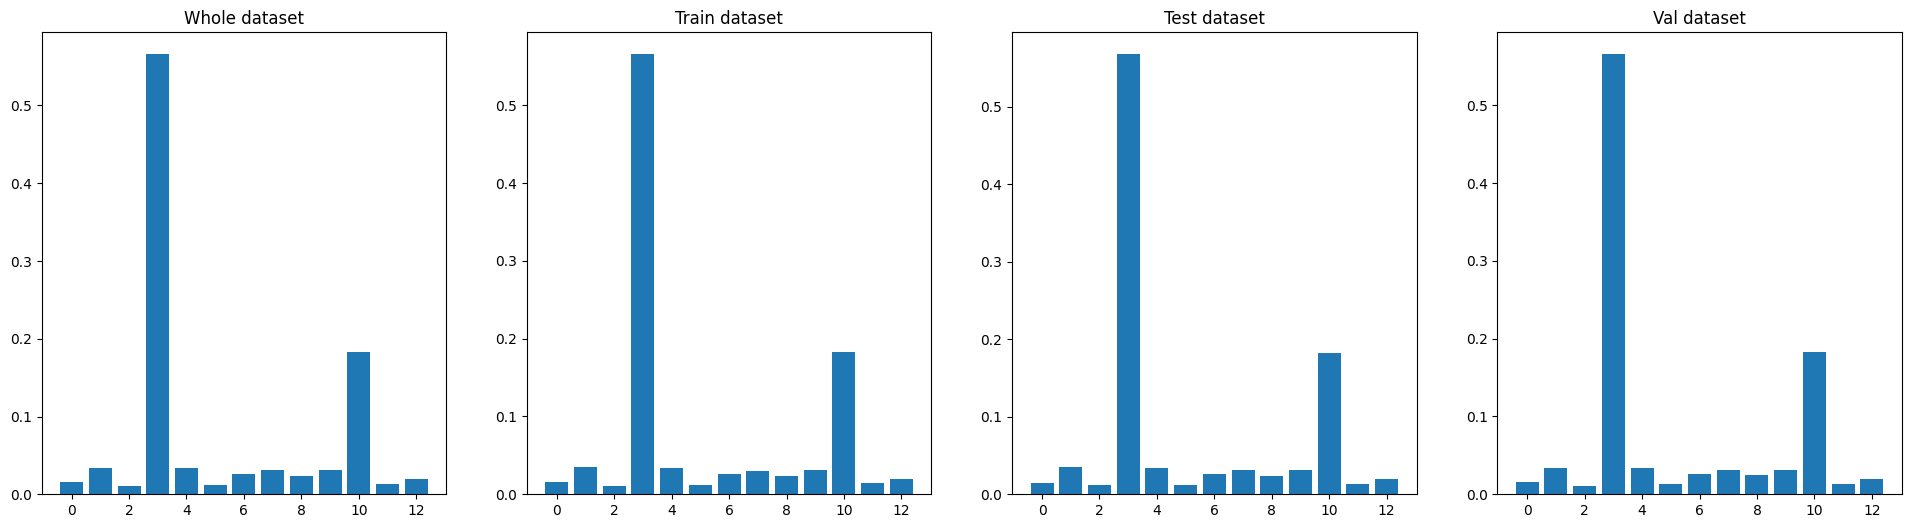

In [3]:
plot_split_stratification(dataset, train_subset, test_subset, val_subset)

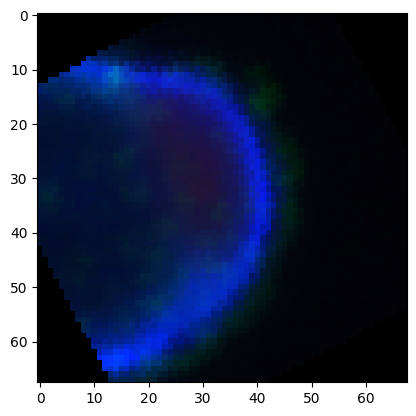

In [4]:
# get a sample image from the dataset
sample = dataset[612][0]

# show the image
show_img(sample.view(3,68,68))


In [5]:
# test how a sample looks
x, y = next(iter(train_loader))
print(x.shape, y.shape)

torch.Size([96, 3, 68, 68]) torch.Size([96])


# VAE

In [6]:
from models import VAE_LAFARGE_v2
# from loss_functions import loss_function_elbo_3 as loss_function
from loss_functions import loss_function_mean as loss_function
latent_dim = 256
hidden_dim = 2*latent_dim

model = VAE_LAFARGE_v2(input_dim=(3,68,68), hidden_dim=hidden_dim, latent_dim=latent_dim)
print(model)

if cuda:
    model = model.cuda()

lr = 5e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=lr)

# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


VAE_LAFARGE_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (11): LeakyReLU(negative_slope=0.01)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

In [7]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
x_hat = output["x_hat"]
print(f"x_hat.shape: {x_hat.shape}")

assert x_hat.shape == x.shape

x.shape: torch.Size([96, 3, 68, 68])
x_hat.shape: torch.Size([96, 3, 68, 68])


In [8]:
# define dirs for the saving of model / data
MODEL_NAME = f"{model.__class__.__name__}_latent{model.latent_dim}_mean_"
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

print(MODEL_NAME)


VAE_LAFARGE_v2_latent256_mean_


## Training

In [9]:
val = True

num_epochs = 50
train_loss = []
train_mse_loss = []
train_kld_loss = []
val_loss = []
val_mse_loss = []
val_kld_loss = []

val_train_loss = []
val_train_mse_loss = []
val_train_kld_loss = []


best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    mse_batch_loss = []
    kld_batch_loss = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x = x.cuda()

        optimizer.zero_grad()
        output = model(x)
        x_hat, mu, sigma = output["x_hat"], output["mu"], output["sigma"]
        loss_fn = loss_function(x, x_hat, mu, sigma)
        mse_loss = loss_fn["MSE"]
        kld_loss = loss_fn["KLD"]
        loss = loss_fn["loss"]

        loss.backward()
        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)


        optimizer.step()

        batch_loss.append(loss.item())
        mse_batch_loss.append(mse_loss.item())
        kld_batch_loss.append(kld_loss.item())
        

    train_loss.append(np.mean(batch_loss))
    train_mse_loss.append(np.mean(mse_batch_loss))
    train_kld_loss.append(np.mean(kld_batch_loss))

    if val:
        model.eval()
        batch_loss = []
        mse_batch_loss = []
        kld_batch_loss = []

        with torch.no_grad():
            for x, y in val_loader:
                if cuda:
                    x = x.cuda()

                output_val = model(x)
                x_hat, mu, sigma = output_val["x_hat"], output_val["mu"], output_val["sigma"]
                loss_fn = loss_function(x, x_hat, mu, sigma)
                mse_loss = loss_fn["MSE"]
                kld_loss = loss_fn["KLD"]
                loss = loss_fn["loss"]

                batch_loss.append(loss.item())
                mse_batch_loss.append(mse_loss.item())
                kld_batch_loss.append(kld_loss.item())

            val_loss.append(np.mean(batch_loss))
            val_mse_loss.append(np.mean(mse_batch_loss))
            val_kld_loss.append(np.mean(kld_batch_loss))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                torch.save(model.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")
    print(f"Epoch {epoch+1}/{num_epochs}, loss: {train_loss[-1]}, mse_loss: {train_mse_loss[-1]}, kld_loss: {train_kld_loss[-1]}, val_loss: {val_loss[-1]}, val_mse_loss: {val_mse_loss[-1]}, val_kld_loss: {val_kld_loss[-1]}")
    
    # plot_latent(output)



Epoch 1/50, loss: 214.75328974804387, mse_loss: 184.65081157069054, kld_loss: 30.102478847708753, val_loss: 1450171166456.8015, val_mse_loss: 112.49202718898763, val_kld_loss: 1450171166344.612
Epoch 2/50, loss: 142.1277147823398, mse_loss: 113.28853781095115, kld_loss: 28.839177498180195, val_loss: 16891.87702119907, val_mse_loss: 96.07749419716124, val_kld_loss: 16795.7992395476
Epoch 3/50, loss: 133.11235757291593, mse_loss: 102.51016921411096, kld_loss: 30.602188554520616, val_loss: nan, val_mse_loss: 92.63084353510226, val_kld_loss: nan
Epoch 4/50, loss: 127.85441076275757, mse_loss: 96.91094816943284, kld_loss: 30.94346237065422, val_loss: 196.22313516790217, val_mse_loss: 90.23613764320018, val_kld_loss: 105.98699556111704
Epoch 5/50, loss: 126.01394719652683, mse_loss: 94.81751864619336, kld_loss: 31.19642820343627, val_loss: 117.43641140537122, val_mse_loss: 86.30351756890224, val_kld_loss: 31.13289300932638
Epoch 6/50, loss: 124.47496380080825, mse_loss: 93.03706856301304, kl

# Evaluate model on test set

In [10]:
# we evaluate model on test set
test_loss = []
test_mse_loss = []
test_kld_loss = []
model.eval()

for x, y in test_loader:
    if cuda:
        x = x.cuda()

    output_test = model(x)
    x_hat, mu, sigma = output_test["x_hat"], output_test["mu"], output_test["sigma"]
    loss_fn = loss_function(x, x_hat, mu, sigma)
    mse_loss = loss_fn["MSE"]
    kld_loss = loss_fn["KLD"]
    loss = loss_fn["loss"]

    test_loss.append(loss.item())
    test_mse_loss.append(mse_loss.item())
    test_kld_loss.append(kld_loss.item())

print(f"Test loss: {np.mean(test_loss)}, Test mse loss: {np.mean(test_mse_loss)}, Test kld loss: {np.mean(test_kld_loss)}")

Test loss: 109.24666288632794, Test mse loss: 77.39957600521362, Test kld loss: 31.847086382240438


## Plots

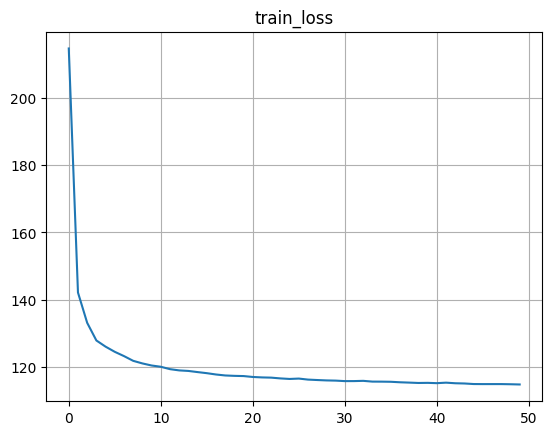

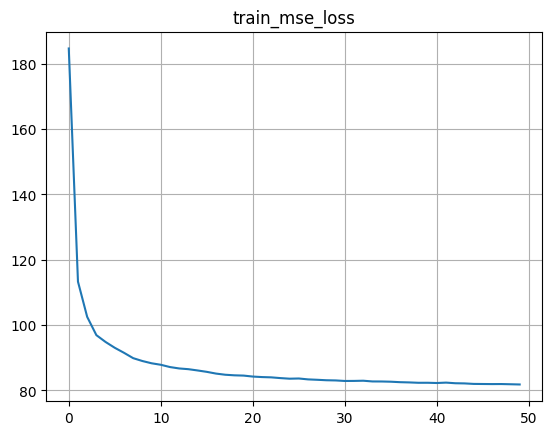

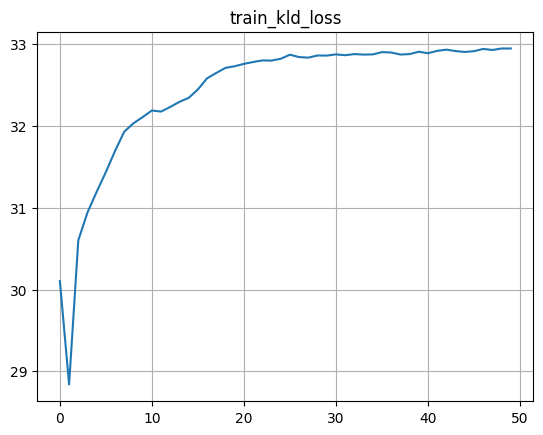

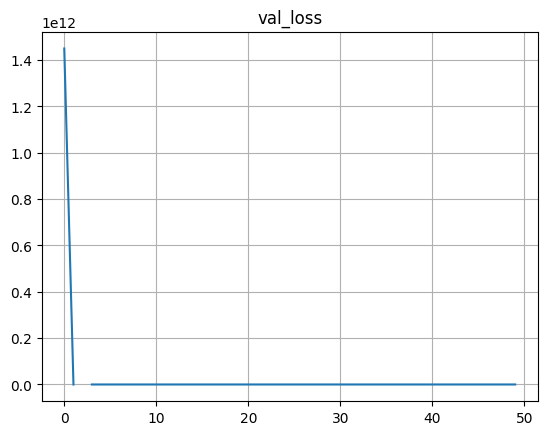

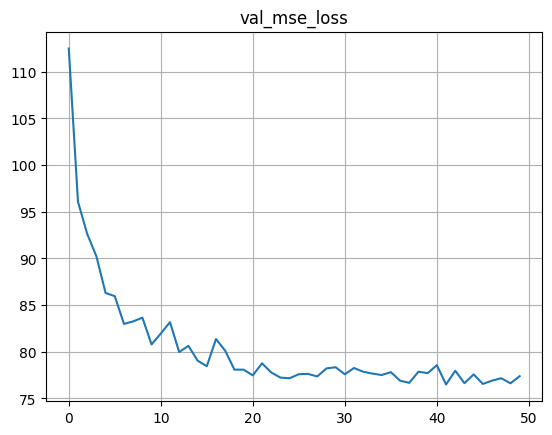

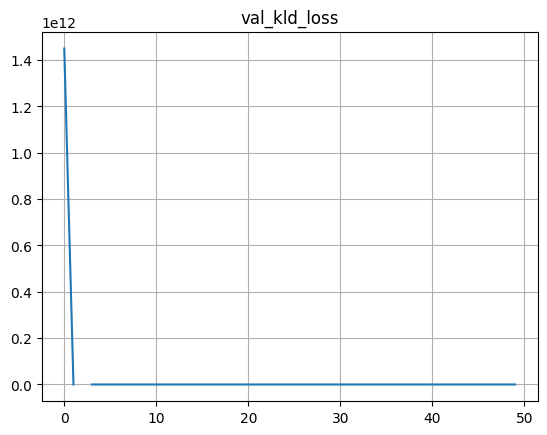

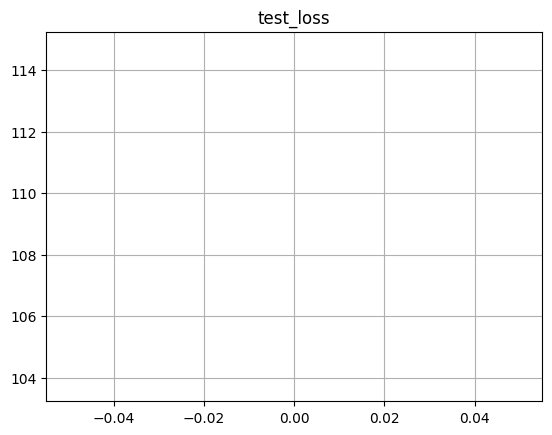

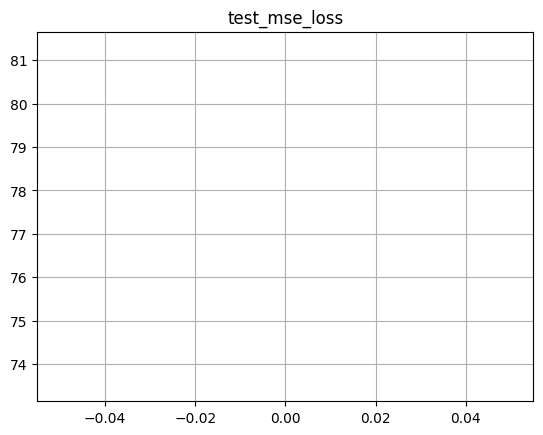

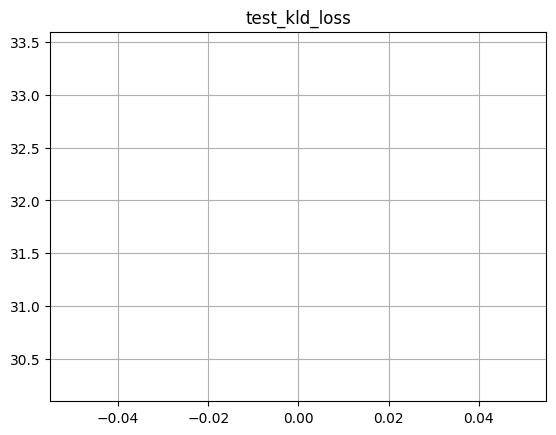

In [11]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["train_mse_loss"] = train_mse_loss
loss_data["train_kld_loss"] = train_kld_loss
loss_data["val_loss"] = val_loss
loss_data["val_mse_loss"] = val_mse_loss
loss_data["val_kld_loss"] = val_kld_loss
loss_data["test_loss"] = np.mean(test_loss)
loss_data["test_mse_loss"] = np.mean(test_mse_loss)
loss_data["test_kld_loss"] = np.mean(test_kld_loss)

loss_plots(loss_data, invidual_plots=True, title="")

df = pd.DataFrame(loss_data)
try:
    old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "loss_data.csv", index=False)


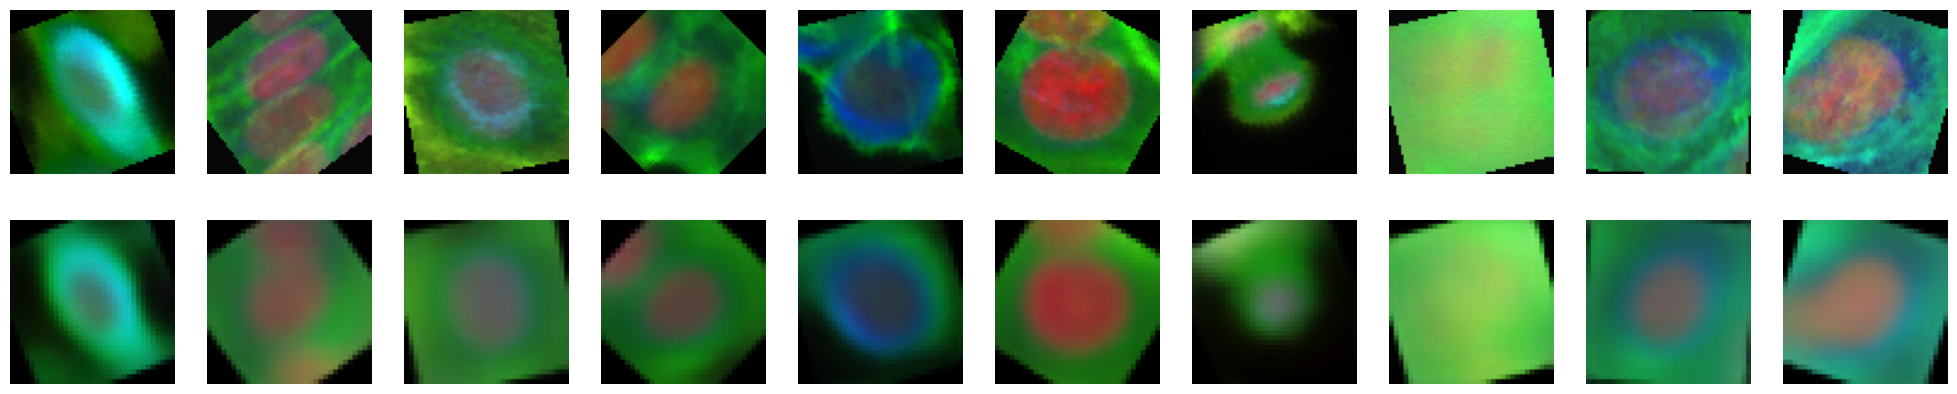

In [12]:
# test the model
plot_image_comparison(model, test_loader, cuda, img_shape=(3,68,68))


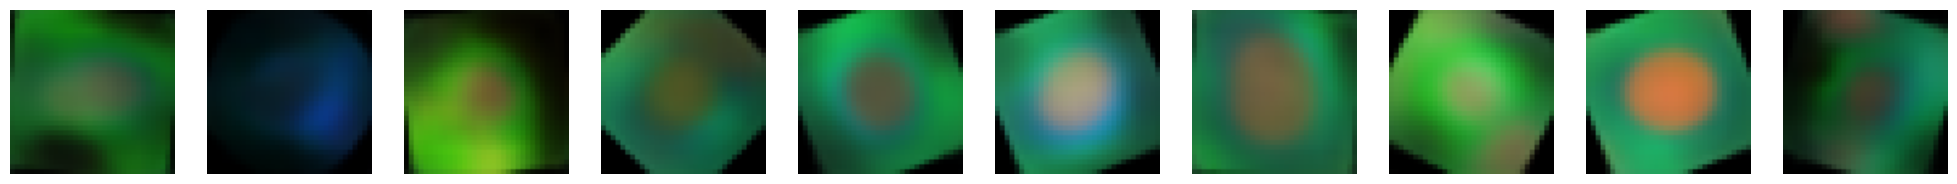

In [13]:
# plot random images generated from the model
plot_random_images(model, n=10, img_shape=(3,68,68), cuda=cuda)

In [14]:
# from inference import Inference

# inference = Inference(model, test_loader)

In [15]:
# samples = inference.samples

In [16]:
# show_img(samples['1'][3])